# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

*conda env: ericsson-deep-research*

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [38]:
import os
import dotenv

dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [39]:
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client,
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [40]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents SDK** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [41]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [42]:
# from azure.ai.projects.models import BingGroundingTool

# bing_connection = project_client.connections.get(
#     connection_name=os.environ["BING_CONNECTION_NAME"]
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="BingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions="""
# You are a web search assistant. When provided with a search query, 
# use your web search tool (BingGroundingTool) to retrieve relevant results.

# ALWAYS FORMAT YOUR RESPONSE AS VALID JSON FOLLOWING THIS EXACT STRUCTURE:
# {
#     "subtopic": "the subtopic that was researched",
#     "query": "the actual search query you used",
#     "results": [
#         {
#             "title": "result title",
#             "full_text": "The complete content retrieved from the search result",
#             "url": "https://example.com/page",
#             "source": "name of the source (optional), if not available, use an empty string",
#             "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
#         }
#     ]
# }

# DO NOT include any text outside of this JSON structure.
# Ensure all JSON is properly formatted with quotes around keys and string values.
# For any optional fields that are unknown, use null instead of omitting the field.

# Include at least 3 relevant results for each search."""
# )

**OpenAI Agents**

In [ ]:
from agents import (
    Agent,
    ModelSettings
)

planner_agent = Agent(
    name="PlannerAgent",
    instructions="""
    You are an expert research planner specializing in creating detailed research plans
    Your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """,
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. When given content from search results, "
        "create detailed, information-rich summaries that: \n"
        "1. Extract ALL important facts, statistics, findings, and insights relevant to the subtopic\n"
        "2. Preserve specific numbers, percentages, dates, and technical details whenever present\n"
        "3. Include industry-specific terminology and concepts that add depth to the research\n"
        "4. Maintain the source's key arguments and conclusions\n"
        "5. Provide thorough explanations rather than superficial overviews\n"
        "6. Each summary should be at least 150-250 words to ensure sufficient detail and context\n\n"
        "7. For technical content, preserve methodologies, technical specifications, and implementation details\n"
        "8. For comparative content, maintain all sides of the comparison with their specific attributes\n\n"
        
        "Remember that your summaries serve as the foundation for generating a comprehensive research report. "
        "The quality and depth of the final research report depends directly on how comprehensive your summaries are.\n\n"
        
        "FORMAT YOUR SUMMARY AS:\n"
        "KEY INSIGHTS: [2-3 bullet points of the most critical takeaways]\n\n"
        "[Detailed paragraph-form summary with maximum relevant information]"
    ),
    model=chatModel,
    output_type=str,
    model_settings=ModelSettings(
        max_tokens=16384,
        temperature=0.3,
    )
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with clear hierarchical organization (main sections, subsections, sub-subsections). "
        "Each major section should be rich in data, explanations, and narratives.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"
        
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, "
        "with minimal use of bullet points and maximum depth in paragraph form."
    ),
    model=reasoningModel,
    output_type=ComprehensiveResearchReport
)


peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=reasoningModel,
    output_type=PeerReviewFeedback,
)

**hand-offs**

In [44]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

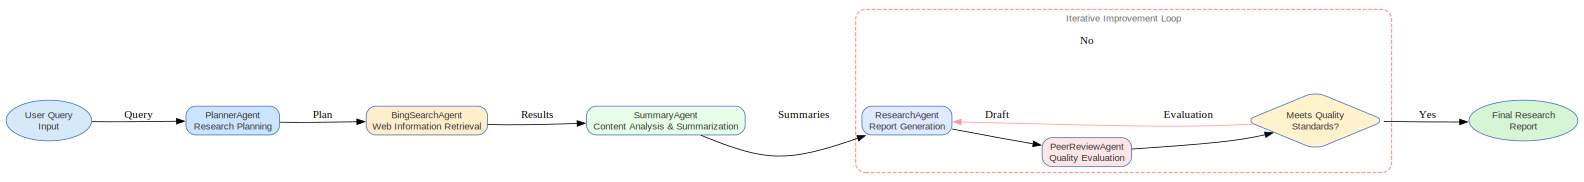

In [45]:
# How to use the module
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [46]:
user_query="What's the latest news in the field of AI? And how what big industries will be affected by it?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [47]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [48]:
from azure.ai.projects.models import MessageRole
from common.utils_search import parse_search_results
from tqdm import tqdm

search_results = []
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}
    
    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: "{query}"
        This is related to subtopic: "{subtopic.subtopic}"
        
        IMPORTANT: Your response must be a valid JSON object matching this structure:
        {{
            "subtopic": "{subtopic.subtopic}",
            "query": "{query}",
            "results": [
                {{
                    "title": "result title",
                    "full_text": "The complete content retrieved from the search result",
                    "url": "https://example.com/page",
                    "source": "name of the source (optional), if not available, use an empty string",
                    "published_date": "YYYY-MM-DD (optional), if not available, use an empty string"
                }}
            ]
        }}
        """
        
        # Create new thread for each query
        thread = project_client.agents.create_thread()
        message = project_client.agents.create_message(
            thread_id=thread.id,
            role=MessageRole.USER,
            content=formatted_query,
        )

        # Process the run
        run = project_client.agents.create_and_process_run(
            thread_id=thread.id,
            agent_id=bing_search_agent.id
        )
        
        # Get the response text
        messages = project_client.agents.list_messages(thread_id=thread.id)
        if messages.get_last_text_message_by_role(role=MessageRole.agent).text.value:
            text_response = messages.get_last_text_message_by_role(role=MessageRole.agent).text.value
            
            # Parse the text response into structured data
            parsed_results = parse_search_results(text_response)
            
            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "results": parsed_results.results  # This will be a list of SearchResultItem objects
            })

        # Delete Thread when done
        project_client.agents.delete_thread(thread_id=thread.id)
    
    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [02:42<00:00, 32.52s/it]


In [49]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 15

Actually total search queries: 15



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [50]:
mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    task_summaries = []
    citations = []

    for query_result in subtopic_result["queries"]:
        for search_result_item in query_result["results"]:
            content_to_summarize = f"{search_result_item.title}: {search_result_item.full_text}"
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=f"Summarize the following content:\n{content_to_summarize}"
            )
            task_summaries.append(summary_response.final_output)
            
            citations.append(Citation(
                title=search_result_item.title,
                url=search_result_item.url
            ))

    mapped_chunks.append({
        "subtopic": subtopic_result["subtopic"],
        "summaries": task_summaries,
        "citations": [citation.model_dump() for citation in citations]
    })


Summarizing subtopics: 100%|██████████| 5/5 [02:43<00:00, 32.67s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [51]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report"
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [66]:
from agents import HandoffCallItem
# from openai.types.responses import ResponseFunctionToolCall

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [67]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# Introduction

Artificial intelligence (AI) has emerged as a pivotal force reshaping the global economy and redefining how businesses operate, innovate, and engage with customers. Three decades ago, AI research primarily focused on rule-based systems and narrow algorithms with limited commercial applications. Today, rapid advances in computing power, data availability, and novel model architectures have converged to unlock applications of AI that reach practically every sector of society. From hyper-personalized recommendations in retail to predictive diagnostics in healthcare, AI is embedded into our daily routines and professional interactions, transforming decision-making, accelerating product development, and opening entirely new avenues for growth.

Recent breakthroughs in AI reflect a fast-paced research community. Academic researchers and industry experts collaborate to push the boundaries in areas such as large language models, multimodal data processing, robotics, and generative systems. Publications like Papers With Code and Springer provide insights into high-impact findings, while platforms like MDPI and ScienceDaily highlight the real-world ramifications of such research in medicine, engineering, and beyond [1]–[6]. The evolution of AI is not limited to model accuracy; it also includes the development of efficient hardware, new regulatory frameworks, and ethical considerations around model interpretability and bias mitigation. Governments and private organizations alike are investing heavily in AI to enhance competitiveness, foresee social changes, and shape the future of work.

Alongside these innovations, AI’s growing pervasiveness has triggered deep structural transformations across industries. Knowledge-intensive sectors such as finance and pharmaceuticals are adopting AI to achieve faster insights and to remain at the cutting edge of research, whereas verticals like manufacturing have begun harnessing AI-driven robotics primarily for automation and predictive maintenance [7]–[10]. In parallel, AI’s influence on business practices is unmistakable. From advanced analytics that inform product development to automated customer service chatbots that handle queries, AI reorients the longstanding norms of strategy and planning by improving both speed and precision. Organizations that effectively integrate AI throughout their operations are reporting better financial performance and innovative new revenue streams, while others remain hesitant to navigate regulatory uncertainties and workforce transformation issues.

Consumer behavior, too, is shifting under the weight of AI-driven personalization. With sophisticated recommendation algorithms guiding potential purchases, consumers increasingly expect frictionless, connected experiences across digital and physical environments. By 2025, forecasts suggest AI will deeply embed itself into routine transactions, augmenting everyday decisions with context-specific suggestions [11]–[16]. However, these shifts also raise ethical questions of privacy, data usage, algorithmic bias, and even the possibility of manipulative marketing. Regulatory bodies around the world are attempting to keep pace through legislation and guidelines that balance innovation and consumer protection.

Finally, leaders in academia and industry consistently emphasize that the implications of AI over the coming years resonate far beyond incremental efficiency gains. They point to AI’s potential for solving large-scale societal problems—from climate modeling and renewable energy management to breakthroughs in pharmaceuticals and medical research. Yet prudent governance is necessary to ensure that AI’s benefits are inclusive and sustainable. In particular, as advanced AI models like generative systems transition from experimental coding labs to mass-market adoption, the need to address ethical, legal, and infrastructure challenges becomes more pressing.

In this report, we examine the most current breakthroughs and trends in AI, highlight the industries that are most profoundly influenced, and explore the broad spectrum of changes in business practices and consumer behavior. We then conclude with an outlook on how AI might shape the future across multiple sectors, considering issues of ethics, workforce impact, and regulatory considerations. By analyzing scholarly discussions, industry surveys, and real-world case studies, this comprehensive overview aims to provide a nuanced understanding of the rapidly shifting AI landscape and what it implies for critical industries, business operations, and society at large.


# 1. Recent Breakthroughs and Trends in AI

AI’s trajectory has been marked by bursts of innovation in key subfields, often enabled by parallel improvements in hardware architectures or the discovery of new algorithms. Today, the spotlight frequently shines on large language models (LLMs), generative AI, robotics, and knowledge augmentation techniques. Scholarly platforms such as Papers With Code highlight how research prototypes quickly shift from academic proof-of-concept to industrial applications in domains like 3D scene understanding, identity-preserved image generation, and knowledge-based language modeling [1]. Meanwhile, publishers like Springer and MDPI underscore the convergence of AI with related fields like neuroscience, linguistics, materials science, and aerospace engineering [2], [3]. This convergence paves the way for an unprecedented breadth of research and cross-disciplinary synergy.

One of the remarkable projects discussed in the academic literature is VGGT, which focuses on extracting attributes from 3D scenes. The significance lies not only in enabling more accurate 3D object recognition but also in supporting complex tasks like autonomous driving, where understanding the geometry and semantics of the environment is crucial [1]. InfiniteYou, another emerging system, uses advanced generative models to produce identity-preserved images, opening possibilities for personalized avatars in gaming, digital identity creation, and even medical imaging. Additionally, Knowledge-Based Language Models (KBLaM) integrate external knowledge sources into language models, aiming to address data constraints and expand factual accuracy [1]. By tapping into vast knowledge repositories, these models can offer deeper human-like comprehension, reduce hallucinations, and inform more precise decision-making.

Alongside these research prototypes, industry leaders have catalyzed progress in AI at an accelerated pace, often guided by economic incentives and the vision to transform vertical markets. Nvidia’s latest AI chips, designed to power autonomous vehicles, exemplify cutting-edge hardware solutions that drastically reduce latency and improve inference speeds in real-time decision scenarios [4]. Meanwhile, collaborations between automakers and tech giants channel these hardware breakthroughs into next-generation transportation systems. Similarly, Google DeepMind’s robotics initiatives revolve around the Gemini AI model, where multi-step tasks are encoded and executed with near-human dexterity [4]. The demonstration of these robotic arms hints at a more generalized automation future, one where AI can adapt to unstructured environments. Such progress appears particularly relevant to industries like logistics and manufacturing.

OpenAI’s roadmap for GPT-4.5 and GPT-5 points to continued development in the realm of large-scale language models, with an emphasis on improved logical reasoning and fact-checking to temper the well-known susceptibility of generative models to produce inconsistent or fabricated outputs. This signals a shift from purely text-based generation to function-rich interactions where AI systems might not only converse but also verify the validity of their claims in real time [4]. The potential applications of these more reliable language models span healthcare diagnostics, legal advisement, and enterprise intelligence.

Beyond raw technological advances, recent reports point to an escalating focus on ethical and responsible AI. Governments are responding to public concern around data privacy, fairness in automated decisions, and transparency in AI-driven systems. For instance, the UK’s AI Safety Bill aims to establish guidelines for accountability and oversight, aligning with broader international movements for careful AI governance [4], [7]. Ethical frameworks have also expanded to address the carbon footprint of AI training and the environmental impact of data centers that power large-scale computations. As AI systems grow in both size and complexity, sustainability concerns weigh heavily on governments and businesses seeking to build a robust, responsible AI ecosystem.

Academic circles are simultaneously pushing frontiers in applied AI. Healthcare stands at the front lines of AI adoption, with innovations in medical diagnostics, drug discovery, and patient care management. MDPI’s 2023–2024 publications reflect strong momentum in applying explainable AI for autism diagnosis, advanced signal processing for image-based disease detection, and deep transfer learning for analyzing limited data scenarios [3]. Meanwhile, aerospace engineering research explores AI-based defect detection systems that can reduce maintenance costs and enhance safety. Across these initiatives, a common theme emerges: AI is no longer a standalone technology—it is an interdisciplinary enabler that connects expert knowledge in many fields to advanced computational methods.

The concept of benchmark saturation adds context to the broader conversation. Many widely used tests, such as ImageNet for vision or GLUE in NLP, have witnessed AI models surpassing human performance. Experts argue these benchmarks have become ineffective at differentiating cutting-edge systems. Efforts to design next-generation benchmarks are underway to spur AI’s continued progress, focusing on complex tasks that involve reasoning, creativity, and real-world constraints [7]. This wave of new benchmarks, combined with an intensifying emphasis on general-purpose AI systems, suggests that AI development will continue to expand in both depth (specialization in particular tasks) and breadth (adaptation across tasks). The result is an AI ecosystem that thrives on synergy across hardware, algorithms, data, and domain-specific expertise.

In summary, recent breakthroughs in AI hinge on novel architectures (like advanced generative models and knowledge-based LLMs), domain-specific innovations (like 3D scene analysis and identity preservation), and large-scale industrial deployments powered by specialized hardware. These improvements have profound implications, not just for technology enthusiasts, but for entire industrial sectors, public policy, and everyday consumer experiences. Ethical, regulatory, and sustainability considerations represent additional layers of complexity that researchers and practitioners must navigate. Through all of this, the pace of transformation continues to accelerate, making it abundantly clear that AI’s evolution is far from reaching a plateau.


## Data Visualization: Timeline of Selected Major AI Developments (2023–2025)

```mermaid
gantt
dateFormat YYYY-MM
section AI Milestones
VGGT project release :milestone, 2023-02, 1d
InfiniteYou introduced :milestone, 2023-05, 1d
KBLaM approach published :milestone, 2023-07, 1d
Nvidia's new AI chips unveiled :milestone, 2024-01, 1d
Google DeepMind's Gemini robot demo :milestone, 2024-06, 1d
OpenAI GPT-4.5 launch :milestone, 2024-10, 1d
UK's AI Safety Bill passes :milestone, 2025-03, 1d
OpenAI GPT-5 release :milestone, 2025-07, 1d
```


# 2. Industries Most Affected by AI Advancements

AI’s impact on industries is not uniform, with certain sectors experiencing deeper and faster transformations than others. By analyzing recent research, consultancy reports, and real-world implementations, it becomes clear that healthcare, finance, and retail are at the forefront, while other domains, such as manufacturing, logistics, and emerging markets like advanced health financing, also witness tangible AI-driven shifts [8]–[10], [17]. Additionally, specialized research reveals how AI shapes the aerospace, defense, and education sectors, though in varied, context-specific ways.

## 2.1 Healthcare

Healthcare stands as one of AI’s most promising and critical application areas, with the potential for meaningful, life-saving outcomes. Machine learning algorithms excel in diagnostics by analyzing large volumes of patient data, imaging scans, and clinical notes to identify significant patterns sometimes invisible to human clinicians [3], [18]. For instance, deep transfer learning enables automated autism spectrum disorder diagnosis by synthesizing patient features, while other AI applications help detect skin defects or early oncological markers. Personalized medicine initiatives further leverage AI to analyze genomic and lifestyle data, customizing treatment plans to individual patients. As a result, AI-driven improvements not only reduce misdiagnoses and medical errors but also speed up drug discovery by analyzing molecular structures with advanced computational approaches.

AI also plays a significant role in health financing, where scoping reviews show how intelligent systems can streamline resource allocation, predict health expenditure, and support universal health coverage [18]. This underscores the broader notion that AI in healthcare is not confined to the clinical domain. Administrative tasks, health insurance claims management, and scheduling can also be automated, reducing overhead costs and minimizing bureaucratic friction. Consequently, healthcare institutions and policy frameworks are investing heavily in robust data infrastructures and advanced AI solutions. However, they also face an ongoing need for explainable AI methods to justify diagnostic recommendations and ensure transparent decision-making.

## 2.2 Finance

Finance has a longstanding history of adopting advanced computational techniques, making it ripe for further disruption by AI. Fraud detection, risk assessment, and algorithmic trading are central use cases that have been refined through machine learning over the past decade. AI’s power to analyze massive volumes of unstructured data in real time has enabled more accurate credit scoring, improved compliance monitoring, and advanced portfolio management strategies [9], [19]. For example, sophisticated anomaly-detection algorithms identify suspicious transactions within milliseconds, curtailing fraudulent activities.

Looking forward, finance is witnessing an expansion of AI-driven robo-advisors that provide personalized investment advice based on customers’ risk profiles and near-instant assessment of macroeconomic indicators. These tools not only cater to high-net-worth individuals but also democratize investment, making wealth management services accessible to a wider audience. Furthermore, financial institutions integrate AI solutions for regulatory technologies—dubbed RegTech—to automate auditing and adherence to complex financial regulations. The synergy between AI and finance is expected to deepen as large language models become adept at reading legal and regulatory text, thereby providing more accurate guidance on compliance and streamlining back-office operations.

## 2.3 Retail

In retail, AI’s transformative influence is evident both in customer-facing solutions and back-end logistics. Personalized recommendation engines are among the most visible consumer applications. By analyzing browsing behavior, purchase histories, and contextual factors, retailers provide dynamic product suggestions and targeted marketing campaigns. Over half of U.S. consumers report that product recommendations influence their purchase decisions, signifying the potency of algorithm-driven marketing [20]. Chatbots also streamline customer service, while AI-driven inventory management systems use real-time data to optimize stock levels and reduce waste.

Beyond personalization, computer vision algorithms integrated into retail environments can monitor customer foot traffic, detect potential shoplifting, and manage automated checkout systems. Predictive analytics harness historical sales data to forecast demand, ensuring that retailers maintain adequate supply without overstocking. AI-driven solutions also extend to omnichannel strategies, linking online and offline customer behavior for a seamless shopping experience. Such enhancements are not only beneficial for large retailers but also for smaller merchants adopting cloud-based AI services to remain competitive. As the technology continues to mature, experts believe that AI will shape next-generation retail experiences with augmented reality, hyper-personalized user journeys, and fully automated supply chain solutions.

## 2.4 Manufacturing and Logistics

Although often considered “less knowledge-intensive,” manufacturing and logistics stand to gain significantly from AI through automation, predictive maintenance, and improved supply chain coordination. Traditional manufacturing lines increasingly employ AI-powered robotics to perform repetitive or precision-dependent tasks. Sensors throughout factory floors feed into central systems, which detect anomalies and predict machine failures before they result in costly halts. Logistics providers utilize AI clustering and route-optimization algorithms to reduce delivery times and fuel consumption. AI-based defect detection in areas like aircraft skin or automotive assembly lines can enhance safety standards and reduce production errors [3]. By harnessing real-time data from sensors, companies improve yield, lower their operational costs, and respond rapidly to shifts in demand.

One obstacle in manufacturing has been the disparity between the complexity of physical processes and the primarily digital nature of AI solutions. However, integrated software-hardware solutions and the Industrial Internet of Things (IIoT) are bridging that gap. As more low-cost sensors come online and digital fiber is woven into the fabric of factories, the stage is set for an AI-driven transformation in operational excellence. In the coming years, experts predict that manufacturing and logistics will become further enmeshed with AI solutions, raising productivity to unprecedented levels while presenting new questions about workforce readiness and data governance.

## 2.5 Education and Other Emerging Sectors

Education is rapidly evolving under AI’s influence, particularly through adaptive learning platforms that tailor content to individual student needs, thereby enhancing engagement and retention. AI helps assess students’ strengths and weaknesses in real time, offering targeted exercises and resources. Similarly, the aerospace sector benefits from machine learning models that can detect structural defects, optimize flight routes, and facilitate autonomous drone operations. Meanwhile, the energy sector sees potential in AI-driven grid management, predictive maintenance of turbines, and real-time supply-demand balancing.

As these industries illustrate, AI’s impact extends well beyond high-profile sectors like finance and healthcare. The unifying thread remains the capacity to analyze large volumes of data, identify nuanced patterns, and autonomously take corrective or optimized actions. Each domain exploits AI in domain-specific ways, but the baseline requirement for data readiness, skilled expertise, and governance remains consistent across the spectrum.


## Bar Chart: Selected Industries’ Relative AI Adoption Rates

Below is a conceptual illustration showing hypothetical adoption levels for various industries based on aggregated insights from publications and surveys. The percentages do not represent exact figures but illustrate the relative speed and depth of AI integration.

```mermaid
bar chart
    title AI Adoption Rates Across Industries
    axis labels 2023 2024 2025
    series Healthcare [40, 55, 70]
    series Finance [50, 65, 80]
    series Retail [45, 60, 75]
    series Manufacturing [25, 40, 60]
    series Education [20, 35, 50]
```


# 3. AI’s Influence on Business Practices

AI is more than a tool for industry-specific applications; it is also a strategic force that refines how businesses operate, plan, and compete. Organizations are increasingly weaving AI into the fabric of their business models—ranging from product innovation to risk management, and from workflow automation to workforce transformation [1], [2], [21]–[24]. As AI evolves in sophistication, companies face simultaneous opportunities to unlock new value and challenges in governance, ethics, and employee readiness.

## 3.1 Strategic Integration of AI Into Business Functions

One of the most far-reaching effects of AI integration is the fundamental shift in decision-making processes. Historically, corporate leadership relied on descriptive analytics to comprehend what happened in the past, supplemented by executives’ intuition to shape future strategies. AI changes this dynamic by using predictive analytics, and increasingly prescriptive analytics, to map out optimal courses of action. This prescriptive capacity combines large-scale data analysis with scenario modeling to forecast potential outcomes under different decision pathways [22]. As a result, AI can influence everything from inventory planning to product roadmaps, mitigating the risk of human bias and short-sighted judgment.

In fast-paced markets, continuous workflow automation is another hallmark of AI-driven transformation. Tasks that require manual, repetitive input—such as invoice processing, routine data entry, and simple customer inquiries—are prime candidates for AI-powered automation. Chatbots and automated ticketing systems in customer service, for instance, reduce operational costs while maintaining service quality. Automation also surfaces in supply chains, where AI can control routing decisions or negotiate autonomously with vendors using set parameters. Organizations that successfully automate processes with AI often see cost savings, reduced error rates, and improvements in staff productivity, allowing employees to focus on creative or strategic work.

## 3.2 Redesigning Workflows and Leadership Governance

Central to AI’s influence on business practices is the need for organizational reconfiguration. A McKinsey survey reveals that well over three-quarters of sampled companies use AI in at least one business function, and those that realize the highest returns often do so by redesigning their workflows to integrate AI at multiple touchpoints [23]. Workflow redesign may require data to be captured more systematically, ensuring each step in a business process is measurable and thus “machine-readable.” It may also involve senior leadership roles dedicated to overseeing AI adoption and governance, ensuring that advanced analytics and algorithms align with broader corporate values and responsible innovation.

In parallel, organizations investing in AI often hire specialized talent—data scientists, machine learning engineers, AI ethicists—or retrain the existing workforce to fill AI-related roles. Companies recognize that AI is not an off-the-shelf solution but a dynamic capability requiring maintenance, updates, and domain-specific tuning. The synergy between AI specialists and traditional industry experts fosters an interdisciplinary approach, as domain knowledge is critical to refining AI models. Additionally, enterprises increasingly address AI-related risks such as data privacy, algorithmic discrimination, and unintended socioeconomic consequences. By bringing these considerations into standard risk management frameworks, they lay the groundwork for responsible AI implementation.

## 3.3 Business Model Innovation and AI-Driven Product Strategies

AI’s incorporation often transcends operational enhancements, enabling new business model innovation (BMI). According to systematic reviews of AI-driven BMI, organizations leverage AI to offer real-time services, immersive experiences, or even global marketplaces for AI algorithms [25]–[27]. For instance, “pervasive augmented AI” describes embedding AI into daily tools, so that it amplifies human capabilities—this might be a design platform that suggests architectural solutions in real time or a consultancy offering dynamic scenario simulations.

Generative AI technologies open additional frontiers, as they can create text, images, and music with minimal human guidance. Marketers exploit these generation capabilities to create targeted content at scale, while product designers use them to iterate on prototypes. Logistic companies might deploy generative AI to optimize route planning data, factoring in changes to fuel costs and environmental constraints in near real time. Decisions that once took weeks of human deliberation can be reached in hours with AI’s computational heft. This iterative feedback loop, in which AI consistently learns from new data and user behavior, ensures that these business models remain adaptive and resilient.

## 3.4 Emerging Challenges: Ethics, Workforce Transition, and Competitive Pressures

The widespread introduction of AI-based automation inevitably triggers workforce concerns about job displacement. However, many organizations find that AI adoption reshapes roles rather than eliminates them outright. Repetitive tasks become automated, but new roles emerge in areas including AI supervision, data curation, and creative strategizing. Hence, businesses must invest in retraining programs to help employees navigate this evolution and to fill the pipeline with AI-savvy talent.

Ethical considerations also figure prominently in AI’s ascendance. The use of massive data sets for training raises potential privacy infringements, particularly if consumer data is repurposed or shared without explicit consent. Similarly, AI’s capacity to inadvertently encode biases from skewed training samples can lead to unwanted discrimination in hiring processes, credit decisions, or other high-stakes applications [22]. Data audits, transparent algorithm evaluation, and standardized ethical oversight structures are becoming the norm to minimize reputational risks and maintain public trust.

Finally, businesses face rising competitive pressures in an economy where agility and customized engagement have become baseline expectations. Larger organizations with greater resources—both in terms of capital and technical know-how—often achieve faster AI adoption. However, cloud-based AI solutions and open-source innovation also open doors for smaller firms. The net result is a dynamic, highly competitive environment where strategic AI adoption can be a critical determinant of market leadership.


# 4. Consumer Behavior Changes Due to AI

As AI gains ubiquity in everyday applications, it exerts a profound influence on consumer decision-making, expectations, and interactions with brands. Marketing and personalization stand at the forefront: algorithms craft experiences tailored to individuals, prompting shifts in what customers buy, how they perceive products, and their loyalty to particular brands. A growing body of research underlines that AI has transitioned from merely analyzing historical consumer behavior to actively shaping it [28]–[32].

## 4.1 From Predictive to Prescriptive Analytics

Early AI applications in retail and marketing primarily hinged on predictive analytics that analyzed historical data to forecast future needs. Advances in generative and reinforcement learning have now propelled the field into prescriptive analytics, where AI actively suggests actions to influence consumer decisions [28]. For instance, e-commerce sites not only display product recommendations but also dynamically adapt website layouts and promotional messages to steer consumers toward higher-margin items or categories that align with emerging trends. The capacity to influence rather than simply observe consumer activity highlights the two-way interaction between AI and human preferences.

The shift toward prescriptive analytics draws attention to ethical considerations in marketing, especially when personalization verges on micro-targeting or manipulative persuasion. Regulation and consumer advocacy groups are voicing concerns that such AI-driven targeting can exploit cognitive biases or limited consumer awareness to drive sales. Brands must tread carefully to ensure that the personalization strategies they employ do not cross ethical boundaries or compromise consumer trust.

## 4.2 Personalization and Heightened Consumer Expectations

Hyper-personalization in customer journeys is arguably AI’s most visible impact on consumer behavior. Recommendation engines now consider not only a person’s purchase history but also contextual signals such as time of day, weather, recent browsing patterns, and geolocation. In streaming and entertainment, platforms like Netflix, Amazon Prime, and YouTube fine-tune content recommendations based on fine-grained consumption habits. Such bespoke experiences often delight consumers, but they also raise expectations that every brand interaction should be equally personalized.

This phenomenon can spur an “AI arms race” among brands competing to deliver more intuitive and frictionless journeys across channels. The retail environment, for example, harnesses AI-driven chatbots to facilitate immediate customer support, while dynamic pricing models adjust costs on the fly. Meanwhile, inventory management systems ensure the right product is stocked at the right place. These features create consumer loyalty ecosystems, as customers come to rely on streamlined, consistent brand interactions [29]–[32].

## 4.3 Changing Patterns of Consumer Decision-Making

AI-driven marketing does more than simplify the shopping experience; it can also reshape consumers’ fundamental decision patterns. Research shows that targeted advertising leveraging AI fosters quicker purchase decisions by providing highly relevant information at exactly the right stage in the buyer’s journey [30]. The insertion of AI chatbots and recommendation widgets within e-commerce or smartphone apps further automates the flow, creating minimal friction from want to purchase. In highly significant impact areas like healthcare or finance, AI-supported interfaces also expedite consumer decisions by clarifying complexities (e.g., explaining insurance plan benefits) in user-friendly terms.

Concurrently, consumer reliance on external AI-based tools—such as smart speakers, personal digital assistants, and automated comparison websites—reduces the likelihood that shoppers conduct extensive independent research. This could shift brand dominance toward those that excel at negotiating AI-driven gatekeepers or those that feed these gatekeepers with robust, high-quality data about their products. As a result, brand marketing strategies increasingly revolve around fostering synergy with AI channels, ensuring that brand attributes and product details are effectively communicated through these new digital arbiters.

## 4.4 The Role of Trust, Transparency, and Ethical Consumerism

As AI gains more control in consumer funnels, trust has emerged as a crucial factor in shaping brand relationships. Consumers now demand transparency around how algorithms make recommendations, what data is being collected, and how that data is used. Data privacy scandals and revelations of manipulative targeting have begun to erode public confidence in certain AI-driven systems, prompting heightened interest in “ethical consumerism.” Consequently, brands that demonstrate responsible AI usage—through data minimization, explicit opt-in policies, or unbiased algorithm designs—are better positioned to cultivate loyalty [29].

Some organizations have capitalized on this shift toward conscientious consumption by implementing “ethical-by-design” frameworks. For example, retailers can highlight fair trade or sustainable sourcing in product recommendations. Others adopt transparent AI labeling, indicating when consumers are interacting with a chatbot versus a human representative. These measures not only respond to consumer demands for honesty but also can differentiate a brand in crowded markets that rely increasingly on AI-driven personalization.

## 4.5 AI-Powered Marketing and the Future Retail Ecosystem

Looking ahead, generative AI solutions promise even more immersive consumer experiences. Examples include virtual fitting rooms, AI-assisted product customizations, and on-the-spot feedback from digital stylists or health coaches. As AR and VR technologies converge with AI, consumers may explore virtual stores or preview how products fit their homes via realistic simulations. This level of interactivity is bound to shape expectations for convenience, personalization, and immediacy. However, it also intensifies the complexities of balancing personalization with privacy. Maintaining that balance will be an essential factor in preserving brand trust in an era where AI not only tracks consumer behavior but also proactively shapes it.


# 5. Future Implications of AI in Industries

Forecasts suggest that AI will continue to shape industries at an accelerating pace, unlocking new forms of innovation while posing challenges in ethics, regulation, and workforce reorientation. Publications by PwC, IBM, and research institutes around the globe converge on the view that AI will become an essential layer across enterprise functions, ceding greater autonomy to automated systems while requiring strategic oversight to manage risk [33]–[41].

## 5.1 Emerging Trends: Generative AI, Autonomous Systems, and Beyond

Generative AI is perhaps the most talked-about future trend, given its capacity to create new content—text, images, music—based on learned patterns. By 2025, experts foresee more advanced generative systems seamlessly integrated into organizations’ design processes, content creation workflows, and R&D initiatives [35]. Autonomous systems, including self-driving vehicles and warehouse robots, are also on the cusp of breaking into mainstream usage. Logistics, public transportation, and manufacturing lines will likely expand their reliance on AI-based autopilot capabilities, tackling tasks too menial or hazardous for human workers. This integration of autonomous systems epitomizes a major leap forward in efficiency, though concerns remain around safety, legal liability, and workforce displacement.

Additionally, AI-powered decision-making tools will facilitate more granular data analysis. Especially in finance, a new wave of real-time decision engines can evaluate credit applications, investment opportunities, or potential fraud based on rapidly evolving data streams. In settings like oil and gas or chemical manufacturing, advanced robotics combined with AI can further reduce operational risk. Yet each of these leaps in robotics, generative modeling, and real-time analytics intensifies the demand for robust infrastructure, specialized talent, and governance that ensures these systems operate in a fair and explainable manner.

## 5.2 The Escalating Importance of Ethical and Sustainable AI

As AI systems proliferate, so do concerns around their social and environmental impacts. The resource intensity of training large-scale models is climbing, raising questions about carbon footprints and energy consumption [4], [7], [36]. In parallel, ethical issues ranging from inherent model biases to data privacy have amplified calls for improved regulatory scrutiny. Bodies like the OECD have released reports emphasizing the importance of strategic governance to guide AI’s development, mitigate social inequalities, and ensure transparent decision-making [40].

Looking toward 2025 and beyond, a plausible scenario sees governments worldwide implementing stricter AI-focused legal frameworks that require companies to demonstrate fairness, accountability, and minimal environmental impact. Industries could be required to adopt “green AI” strategies that optimize computational resources, leverage model distillation techniques to reduce complexity, and rely on carbon-offset programs to neutralize training emissions. These frameworks would position AI not just as an economic driver, but also as a responsible participant in global sustainability efforts.

## 5.3 Workforce Transformation and Hybrid Human-Digital Collaboration

While AI augments productivity by automating repetitive tasks, the net effect on labor markets is more complex. PwC’s 2025 AI Business Predictions anticipate a potential doubling of workforce productivity, in part by deploying AI agents that assist in everything from routine clerical tasks to advanced data analytics [33]. This shift demands that businesses adopt a “human-digital hybrid” approach, wherein employees partner with AI solutions to enhance job performance. Rather than fully displacing human labor, AI can complement human capabilities by absorbing low-skill tasks and augmenting complex decision-making.

However, industries will face a skills gap as roles evolve to require deeper data literacy and familiarity with AI tools. Companies that invest early in comprehensive training and workforce development will likely fare better in adapting to AI-driven changes. This ongoing transformation creates an impetus for educators, governments, and private institutions to collaborate on reskilling initiatives, ensuring that local workforces remain agile in an era of frequent technological disruption.

## 5.4 Sectoral Visions: Healthcare, Finance, and Retail in 2025

In healthcare, AI-driven breakthroughs in medical imaging, digital therapeutics, and personalized care are expected to accelerate. By combining predictive analytics with genomics, clinicians may have an expanded ability to recommend individualized treatments. Robots could support surgical procedures, and AI triage systems may become a common feature in patient intake, reducing wait times while improving the accuracy of initial diagnoses. Yet data privacy and regulatory approval processes could slow the wide-scale deployment of these novel solutions.

Finance, on the other hand, will deepen its reliance on AI risk engines for real-time credit evaluations and fraud prevention. Automated wealth management platforms are expected to offer globally diversified portfolios to a broad consumer base, in part by analyzing real-time market data. Moreover, blockchain-like technologies might merge with AI, enabling fully autonomous “smart contracts” that self-execute based on continuously analyzed external data. Such transformations will likely prompt new financial regulations to ensure consumer safety and systemic stability.

Retail, having already embraced AI for recommendations and automated operations, may venture deeper into immersive shopping experiences. AR and VR, fused with generative AI, could craft dynamic storefronts that adapt instantaneously to user preferences. AI could also reshape supply chain strategies, helping retailers preempt shipping delays or respond to abrupt changes in consumer demand. In parallel, more advanced consumer analytics will refine marketing and loyalty programs, though brands risk alienating users if personalization strategies appear overly invasive.

## 5.5 Cross-Industry Challenges and Opportunities

Despite the distinct trajectories across industries, a series of cross-cutting challenges will define AI’s future. Data quality and quantity remain central concerns—the adage “garbage in, garbage out” holds especially true as models grow more complex. Ensuring that data reflects diverse populations and operational scenarios becomes crucial in mitigating biases and delivering fair outcomes. Infrastructure demands, whether for high-performance computing in autonomous vehicles or for heavy data flows in real-time analytics, raise capital-investment barriers for smaller firms.

Nonetheless, the potential upside is immense. AI’s ability to unify disparate data, optimize performance, and uncover hidden patterns can spark new waves of innovation. The democratization of AI tools—from open-source software to cloud-based machine learning services—means that even small to mid-sized organizations can experiment with advanced techniques. As competition intensifies on a global scale, those that commit to thoughtful AI strategies—balancing innovation, ethics, and adaptability—are poised to gain durable competitive advantages.


# Conclusion

Artificial intelligence has rapidly ascended from theoretical possibility to practical necessity in many spheres of industry and daily life. The most recent breakthroughs focus on advanced language models, generative capabilities, multimodal data handling, and specialized hardware accelerators, culminating in tangible impacts across fields like healthcare, finance, retail, and beyond. These breakthroughs remain intertwined with broader societal conversations about sustainability, ethics, job displacement, and governance. AI’s transformation of business practices reveals how automation, predictive analytics, and prescriptive methods can reshape organizational structures, streamline decision-making, and spur new business models. Similarly, consumer behavior—marked by heightened expectations of personalization—evolves through frictionless experiences engineered by AI.

Yet the path forward remains challenging. Data modernization and robust infrastructure investments are essential to keep pace with AI’s demands. Ethical frameworks must address issues of privacy, bias, and accountability, while workforce training programs must bridge the skill gap for a world increasingly driven by AI. Moreover, regulatory bodies are beginning to enforce new standards that might curb or guide AI development, especially as we move closer to scenarios like autonomous vehicles or advanced generative models that pose novel societal risks.

Looking toward the next few years, there is a high likelihood that AI will deepen its roots in all major industries, steering new modalities of innovation and strategic thinking. Whether through hyper-personalized shopping experiences, advanced healthcare analytics, or financial robo-advisors, AI solutions promise significant gains in efficiency, productivity, and user satisfaction. At the same time, the AI revolution demands a discerning approach—organizations must weigh the benefits of agile automation against the responsibilities of maintaining equitable, transparent, and sustainable systems. Practices that ensure responsible AI, from governance boards to multi-stakeholder collaborations, will be central to harnessing the power of AI without compromising societal well-being. In essence, the ongoing expansion of AI is both a challenge and an opportunity—a dynamic force capable of reshaping the global landscape in ways unimaginable just a few years ago. Through collaboration, careful regulation, and continued research, AI can address some of the most pressing problems in modern society, while opening new horizons for productivity, creativity, and equitable growth.


### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [68]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To understand the latest developments in AI and analyze the industries most impacted by these advancements.",
  "aggregated_summaries": [
    {
      "subtopic": "Recent breakthroughs and trends in AI",
      "summaries": [
        "**KEY INSIGHTS:**\n- VGGT introduces a novel approach for extracting 3D scene attributes, advancing the field of 3D scene understanding.\n- InfiniteYou focuses on generating identity-preserved images, emphasizing high fidelity in maintaining individual characteristics.\n- KBLaM enhances Large Language Models (LLMs) by integrating external knowledge, improving their contextual understanding and performance.\n\nPapers With Code, a platform dedicated to showcasing cutting-edge machine learning research alongsid